# Week 4 Assignment 2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.decomposition import NMF


In [2]:
MV_users = pd.read_csv('data/users.csv')
MV_movies = pd.read_csv('data/movies.csv')
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
from collections import namedtuple
Data = namedtuple('Data', ['users','movies','train','test'])
data = Data(MV_users, MV_movies, train, test)

Modify the code from Module 3 and add NMF component to the class

In [4]:

class RecSys():
    def __init__(self, data):
        self.data = data
        self.allusers = list(self.data.users['uID'])
        self.allmovies = list(self.data.movies['mID'])
        self.genres = list(self.data.movies.columns.drop(['mID', 'title', 'year']))
        self.mid2idx = dict(zip(self.data.movies.mID, list(range(len(self.data.movies)))))
        self.uid2idx = dict(zip(self.data.users.uID, list(range(len(self.data.users)))))
        self.Mr = self.rating_matrix()
        self.Mm = None
        self.sim = np.zeros((len(self.allmovies), len(self.allmovies)))
        self.W, self.H = self.apply_nmf()

    def rating_matrix(self):
        ind_movie = [self.mid2idx[x] for x in self.data.train.mID]
        ind_user = [self.uid2idx[x] for x in self.data.train.uID]
        rating_train = list(self.data.train.rating)

        return np.array(coo_matrix((rating_train, (ind_user, ind_movie)), shape=(len(self.allusers), len(self.allmovies))).toarray())

    def apply_nmf(self, n_components=5):
        """
        Applies NMF to the Mr rating matrix and returns the user and movie feature matrices.
        """
        nmf_model = NMF(n_components=n_components, init='random', random_state=0)
        W = nmf_model.fit_transform(self.Mr)
        H = nmf_model.components_
        return W, H

    def predict_from_nmf(self, uid, mid):
        """
        Predict a user rating on a movie given userID and movieID using NMF.
        """
        if uid in self.uid2idx and mid in self.mid2idx:
            user_idx = self.uid2idx[uid]
            movie_idx = self.mid2idx[mid]
            predicted_rating = np.dot(self.W[user_idx, :], self.H[:, movie_idx])
            return predicted_rating
        else:
            return 3

    def predict_everything_to_3(self):
        """
        Predict everything to 3 for the test data
        """

        return np.full(len(self.data.test), 3)

    def predict_to_user_average(self):
        """
        Predict to average rating for the user.
        Returns numpy array of shape (#users,)
        """
        user_avg_ratings = {user: self.data.train[self.data.train.uID == user].rating.mean() for user in self.allusers}
        predictions = np.array([user_avg_ratings.get(uid, 0) for uid in self.data.test.uID])
        return predictions

    def predict_from_sim(self,uid,mid):
        """
        Predict a user rating on a movie given userID and movieID
        """
        user_idx = self.uid2idx[uid]
        movie_idx = self.mid2idx[mid]

        rated_movies = self.Mr[user_idx, :] != 0
        sim_scores = self.sim[movie_idx, rated_movies]
        ratings = self.Mr[user_idx, rated_movies]
        predicted_rating = np.dot(ratings, sim_scores) / sim_scores.sum()

        return predicted_rating

    def predict(self):
        """
        Predict ratings in the test data. Returns predicted rating in a numpy array of size (# of rows in testdata,)
        """
        # your code here
        predictions = []
        for index, row in self.data.test.iterrows():
            uid = row['uID']
            mid = row['mID']
            predicted_rating = self.predict_from_sim(uid, mid)
            predictions.append(predicted_rating)

        return np.array(predictions)

    def predict_nmf(self):
        predictions = []
        for index, row in self.data.test.iterrows():
            uid = row['uID']
            mid = row['mID']
            predicted_rating = self.predict_from_nmf(uid, mid)
            predictions.append(predicted_rating)

        return np.array(predictions)

    def rmse(self,yp):
        yp[np.isnan(yp)]=3 #In case there is nan values in prediction, it will impute to 3.
        yt=np.array(self.data.test.rating)
        return np.sqrt(((yt-yp)**2).mean())


class ContentBased(RecSys):
    def __init__(self,data):
        super().__init__(data)
        self.data=data
        self.Mm = self.calc_movie_feature_matrix()

    def calc_movie_feature_matrix(self):
        """
        Create movie feature matrix in a numpy array of shape (#allmovies, #genres)
        """
        Mm = np.zeros((len(self.allmovies), len(self.genres)))
        for idx, movie in self.data.movies.iterrows():
            for genre in self.genres:
                if genre in movie and movie[genre] == 1:
                    Mm[self.mid2idx[movie['mID']], self.genres.index(genre)] = 1
        return Mm

    def calc_item_item_similarity(self):
        """
        Create item-item similarity using Jaccard similarity
        """
        Mm_sparse = csr_matrix(self.Mm)
        num_movies = len(self.allmovies)

        Mm_dense = Mm_sparse.toarray()

        for i in range(num_movies):
            col_i = Mm_dense[i, :]
            for j in range(i + 1, num_movies):
                col_j = Mm_dense[j, :]

                intersection = np.logical_and(col_i, col_j).sum()
                union = np.logical_or(col_i, col_j).sum()
                jaccard_similarity = intersection / union if union != 0 else 0

                self.sim[i, j] = self.sim[j, i] = jaccard_similarity

        np.fill_diagonal(self.sim, 1)
        return self.sim

# Q1. Use non-negative matrix factorization to predict rating

In [5]:
# Load data
cb = ContentBased(data)

# Save RMSE
rmse_values = []

In [6]:
# Perform baseline predictions
yp = cb.predict_everything_to_3()
rmse_values.append(cb.rmse(yp))
print(cb.rmse(yp))

1.2585510334053043


In [7]:
# Perform baseline predictions using user average
yp = cb.predict_to_user_average()
rmse_values.append(cb.rmse(yp))
print(cb.rmse(yp))

1.0352910334228647


In [8]:
# Perform predictions using content based method
cb.calc_item_item_similarity()
yp = cb.predict()
rmse_values.append(cb.rmse(yp))
print(cb.rmse(yp))

/tmp/ipykernel_8469/2559286881.py:68: RuntimeWarning: invalid value encountered in scalar divide
  predicted_rating = np.dot(ratings, sim_scores) / sim_scores.sum()


1.0128116783754684


In [9]:
# Predictions using NMF model
yp = cb.predict_nmf()
rmse_values.append(cb.rmse(yp))
print(cb.rmse(yp))

2.991424555920139


RMSE (Root Mean Square Error) measures the average magnitude of the errors in a set of predictions, without considering their direction.   
It's the square root of the average of squared differences between prediction and actual observation. A lower RMSE value is typically better, indicating that the predictions are closer to the actual ratings.

Here is the table for RMSE

|Method|RMSE|
|:----|:--------:|
|Baseline, $Y_p$=3| 1.2585510334053043|
|Baseline, $Y_p=\mu_u$| 1.0352910334228647|
|Content based, item-item| 1.0128116783754684|
|NMF, n_components=5| 2.991424555920139|

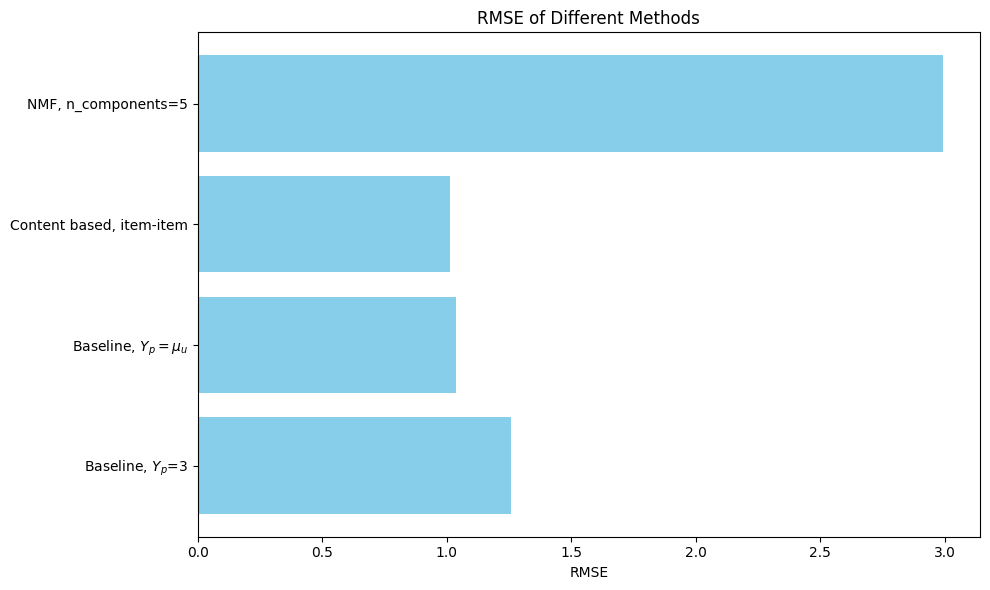

In [10]:
methods = ['Baseline, $Y_p$=3', 'Baseline, $Y_p=\\mu_u$', 'Content based, item-item', 'NMF, n_components=5']

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(methods, rmse_values, color='skyblue')
plt.xlabel('RMSE')
plt.title('RMSE of Different Methods')
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

plt.show()


This plot here shows that the NMF model has worse performance than other method.

## Q2 

Discuss the results and why they did not work well compared to simple baseline or similarity-based methods we’ve done in Module 3. Can you suggest a way(s) to fix it? 

1. NMF may struggle with very sparse matrices, common in recommendation system datasets, where most users rate only a small fraction of items.  
Therefore, we can incorporate additional information (e.g., user or item metadata) to supplement the ratings matrix, potentially using hybrid recommendation techniques that combine content-based and collaborative filtering methods.

2. This NMF model is not fine tuned. Different hyperparameter or initialization method would have different results.  
So, we can do more hyperparameter tuning for better outcomes.

3. NMF model may introduce more overfitting.  
regularization in the NMF model to penalize complexity and encourage the model to learn more generalized patterns.